Кусочек из *Rethinking Ch.7*: подсчет WAIC для модели PyMC3

In [ ]:
from IPython.display import clear_output
!pip install pymc3==3.9
import pymc3 as pm
if pm.__version__ == '3.9.0':
    clear_output()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scipy.stats as stats
from scipy.special import logsumexp
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab/rethinking_data/cars.csv',
                   sep=',', index_col=0)
data.head()

,speed,dist
1,4,2
2,4,10
3,7,4
4,7,22
5,8,16


Наш подопытный 🐰

In [ ]:
with pm.Model() as m1:
    a = pm.Normal('a', mu=0, sigma=100)
    b = pm.Normal('b', mu=0, sigma=100)
    sigma = pm.Exponential('sigma', 1)
    mu = a + b * data['speed']
    dist = pm.Normal('dist', mu=mu, sigma=sigma,
                         observed=data['dist'])
    
    trace = pm.sample(random_seed=89)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.
The acceptance probability does not match the target. It is 0.883116168771548, but should be close to 0.8. Try to increase the number of tuning steps.


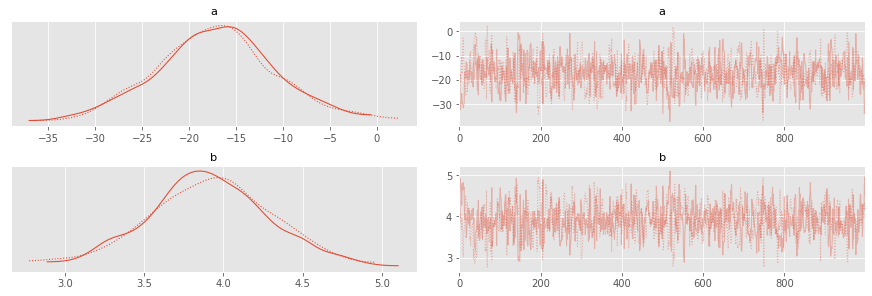

In [ ]:
with m1:
    pm.traceplot(trace, var_names=['a', 'b'])

*We’ll need the log-likelihood of each observation i at each sample s from the posterior:*

In [ ]:
n_samples = 1000
n_cases = len(data)
logprob = np.zeros((n_cases, n_samples))  # (50, 1000)

# итерируемся по выборкам из апостериорного распределения
for s in range(n_samples):
    mu = trace['a'][s] + trace['b'][s] * data['speed']  # вектор длины 50
    logprob[:,s] = stats.norm.logpdf(data['dist'],
                                     loc=mu, scale=trace['sigma'][s])

Мы хотим посчитать lppd: $$\sum_{i}\ln\frac{1}{S}\sum_{s}p(y_i|\theta_s)$$

Если взять экспоненты от логарифмов плотностей и просуммировать их - получится внутренняя сумма по $s$. Затем от нее можно взять логарифм - это все можно сделать функцей `logsumexp()` - останется лишь вычесть $\ln(S)$. Сделаем это для каждой строчки `logprob`.

In [ ]:
lppd = np.zeros(n_cases)
for i in range(n_cases):
    lppd[i] = logsumexp(logprob[i, :]) - np.log(n_samples)

In [ ]:
# lppd
np.sum(lppd)

-206.5884492306983

Теперь обратимся к формуле WAIC: $$-2(\;lppd - \sum_{i}var_{\theta}[\ln p(y_i|\theta)]\;)$$

$var_{\theta}$ означает тут лишь *дисперсию по выборкам из апостериорного распределения*, и у нас уже все есть, чтобы ее посчитать - это будет просто выборочная дисперсия по строкам `logprob`.

In [ ]:
pWAIC = np.zeros(n_cases)
for i in range(n_cases):
    pWAIC[i] = np.var(logprob[i,:])

In [ ]:
# WAIC
-2 * ( np.sum(lppd) - np.sum(pWAIC) )

420.8130256949352

Можно также найти стандартную ошибку WAIC как $$s_{waic}=sd_i(-2(lppd_i - p_i))\sqrt{N}$$

Поскольку элементы векторов `lppd` и `pWAIC` соответствуют отдельным наблюдениям из обучающией выборки.

In [ ]:
np.sqrt(n_cases) * np.std( -2 * (lppd - pWAIC) )

15.839487845947597

In [ ]:
# Кстати, "effective number of parameters":
np.sum(pWAIC)

3.8180636167693134

И в целом вектор `pWAIC` содержит штраф для каждого наблюдения. Его теперь даже можно понять😊 - дисперсия логарифма плотности по выборке из апостериорного распределения. Чем больше, тем хуже!

In [ ]:
speed_seq = np.linspace(np.min(data['speed']),
                        np.max(data['speed']), 100).reshape(-1, 1)
mu = trace['a'] + trace['b'] * speed_seq
mu_upper = np.quantile(mu, 0.945, axis=1)
mu_lower = np.quantile(mu, 0.055, axis=1)
mu_mean = np.mean(mu, axis=1)

Эти штрафы можно посмотреть на картинке снизу, для наглядности добавил их *логарифм* + линию среднего:

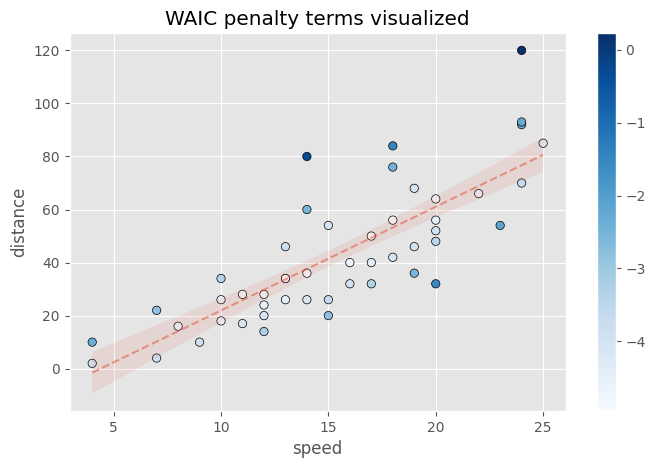

In [ ]:
plt.figure(dpi=100, figsize=[8, 5])

plt.scatter(data['speed'], data['dist'], c=np.log(pWAIC), cmap='Blues', ec='k')
plt.plot(speed_seq, mu_mean, '--', alpha=0.5)
plt.fill_between(speed_seq.flatten(), mu_lower, mu_upper, alpha=0.1)
plt.colorbar()

plt.xlabel('speed')
plt.ylabel('distance')
plt.title('WAIC penalty terms visualized');